In [1]:
import graph_tool.all as gt
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simpson
import random
from tqdm import tqdm
import os

In [2]:
n = 10000

m = 2

times = 100

M_list = [5,10,20,50,100,200]

beta_list = ["+1.0", "+0.5", "0", "-1", "-3", "-5", "-100"]

net_list = ["SF", "Cutoff", "RA", "IPA_beta1", "IPA_beta3", "IPA_beta5", "IPA_beta100"]

In [3]:
from decimal import Decimal

w_list = [0.00, 0.50, 0.70, 0.90, 0.95, 0.98]
w_list = [Decimal(str(item)).quantize(Decimal('0.00')) for item in w_list]

In [4]:
def inter_intra(g):
    # intra, interlinkのリストを初期化
    intra_link = []
    inter_link = []
        
    # intra, interlinkを識別
    for edge in g.edges():
        source_vertex = edge.source()
        target_vertex = edge.target()
    
        if g.vp.module_number[source_vertex] == g.vp.module_number[target_vertex]:
            intra_link.append(edge)
        else:
            inter_link.append(edge)
            
    return intra_link

In [5]:
def module_based_attack(graph, intra_link):
    
    #### 3. コミュニティ間の接続に参加しているノード（またはエッジ）のリストを作成する。 ####
    
    # 空の集合を作成（重複の排除）
    intercommunity_nodes = set()
    # Gの全てのedgeに対してループを回す
    for edge in graph.edges():
        # 現在のedgeの始点ノードを取得
        source_vertex = edge.source()
        # 現在のedgeの終点ノードを取得
        target_vertex = edge.target()
        # 始点ノードと終点ノードが異なるモジュールに所属していれば、
        if graph.vp.module_number[source_vertex] != graph.vp.module_number[target_vertex]:
            # intercommunity_nodesにノードを追加
            intercommunity_nodes.add(source_vertex)
            intercommunity_nodes.add(target_vertex)

    #### 4. (ノードまたはエッジの)間の中心性の降順に従ってリストをソートする。 ####
    # ノードの媒介中心性のリストを返す
    node_betweenness = gt.betweenness(graph)[0]
    # intercommunity_nodesのリストを媒介中心性の高い順にソートする
    sorted_nodes = sorted(intercommunity_nodes, key=lambda v: node_betweenness[v], reverse=True)

    #### 5. リストの先頭から1つずつノード（またはエッジ）を削除する。 ####
    #### 6. 2つのコミュニティ間のリンクからノードが削除されると、他のコミュニティ間の接続にもう一方のノードが参加していない限り、 ####
    ####    そのノードはリストからスキップされる。 ####
    #### 7. 攻撃は常にネットワークの最大連結成分に限定される。####
    
    # 削除されるノードの保存用リストを初期化
    removed_nodes = []
    # ソートされたノードがなくなるまでループ
    while sorted_nodes:
        # リストからノードを取り出す
        node = sorted_nodes.pop(0)
        # ノードがすでにremoved_nodesにないかを確認。リストになければ、、
        if node not in removed_nodes:
            # removed_nodesにノードを追加
            removed_nodes.append(node)

            # そのノードに隣接する全てのノードを取得し、その数だけループを繰り返す
            for neighbor in node.all_neighbors():
                
                # 隣接ノードとそのノードのモジュール番号が違ければ、、、
                if graph.vp.module_number[neighbor] != graph.vp.module_number[node]:
                    # その隣接ノードがまだsorted_nodesに存在すれば、、、
                    if neighbor in sorted_nodes:
                        # sorted_nodesから隣接ノードを削除する
                        sorted_nodes.remove(neighbor)

            # Gの最大連結成分に含まれるノードに対してTrueを、それ以外のノードに対してFalseを持つブールマスクを返す
            lcc_vertex_mask = gt.label_largest_component(graph)
            # Trueとなるノードのみをsorted_nodesに格納
            sorted_nodes = [v for v in sorted_nodes if lcc_vertex_mask[v]]

    # 削除されたノードの数がグラフ graphの全ノード数より少ない場合
    if len(removed_nodes) < graph.num_vertices():
        # まだ削除リストに含まれていないノードのセットを計算
        nodes_not_removed = set(graph.iter_vertices()) - set(removed_nodes)
        # どれだけのノードが削除リストに追加されるべきかを計算
        padding_required = graph.num_vertices() - len(removed_nodes)
    
        # 削除リストに含まれていないノードの数だけループ
        for node in nodes_not_removed:
            # もし、padding_requiredが0になれば、処理を終了
            if padding_required <= 0:
                break
            # 削除リストノードを追加
            removed_nodes.append(node)
            # 必要なノード数を１減少
            padding_required -= 1

    #print(len(removed_nodes))
    # リストを逆順に。
    removed_nodes.reverse()
    return removed_nodes

モジュール数とリワイヤリング率、シミュレーション回数に着目した繰り返し処理

100%|██████████| 100/100 [02:58<00:00,  1.79s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


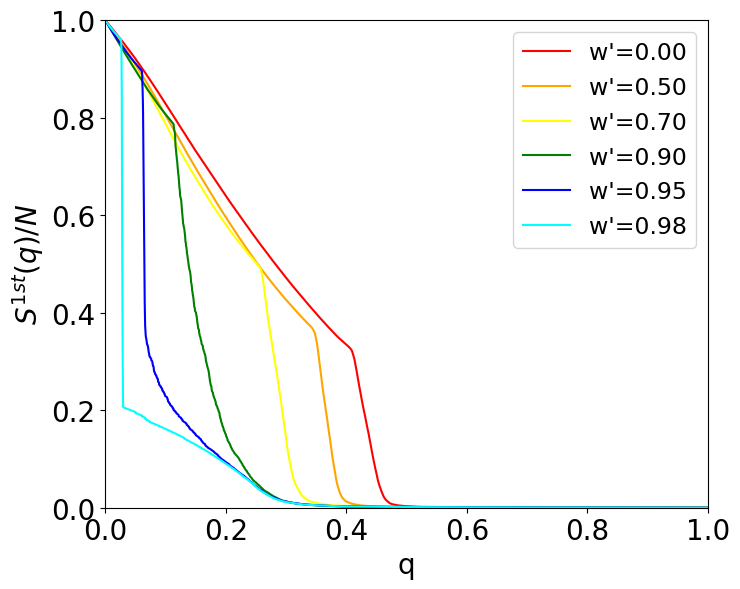

100%|██████████| 100/100 [03:02<00:00,  1.82s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


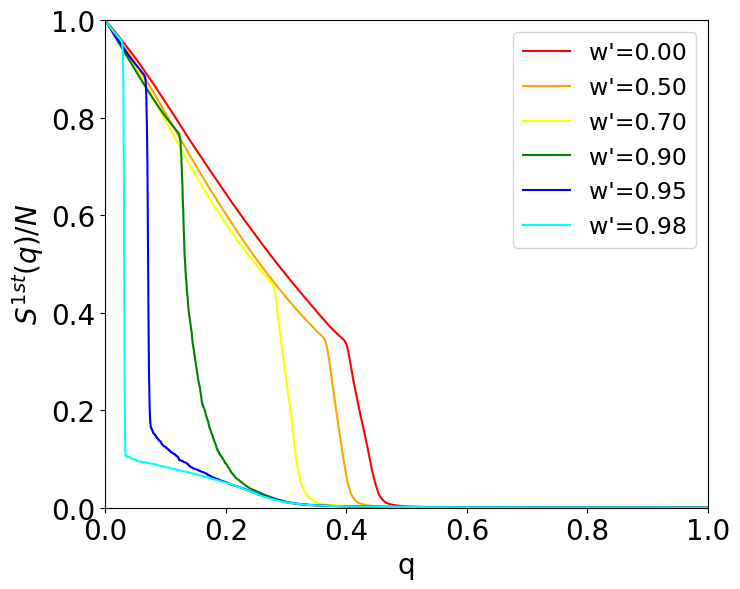

100%|██████████| 100/100 [02:59<00:00,  1.80s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


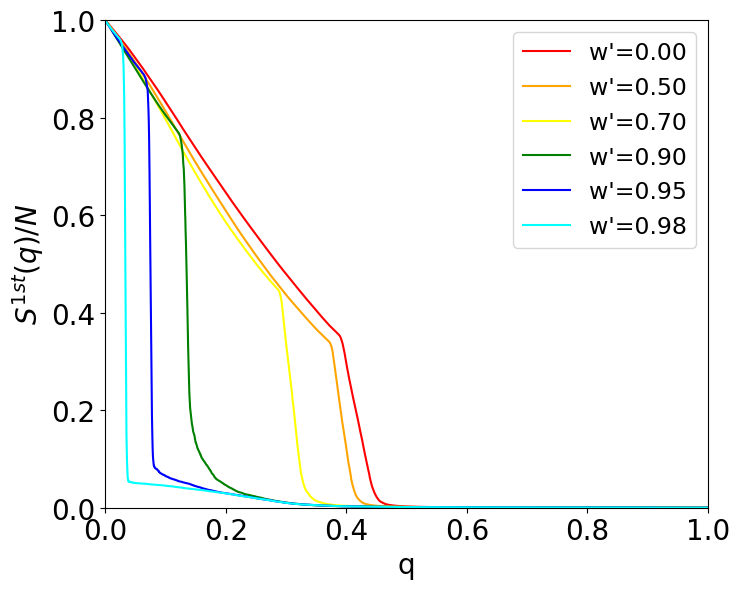

100%|██████████| 100/100 [03:03<00:00,  1.84s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


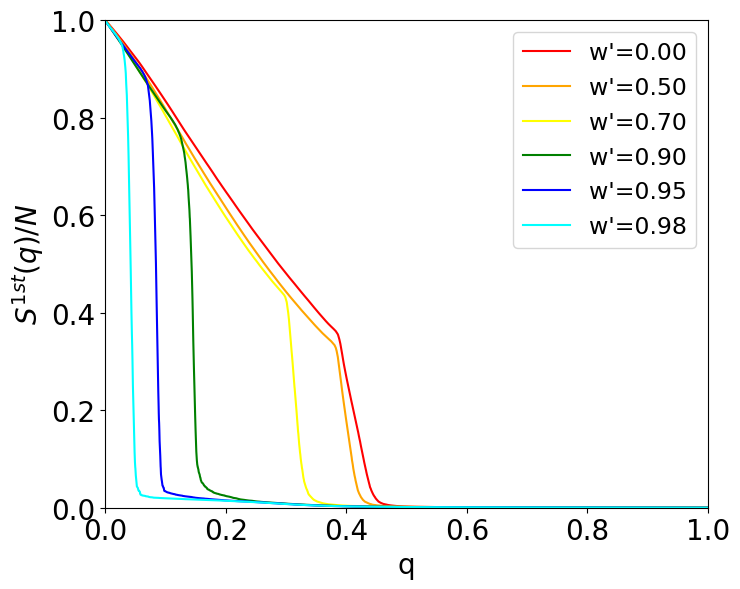

100%|██████████| 100/100 [03:28<00:00,  2.08s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


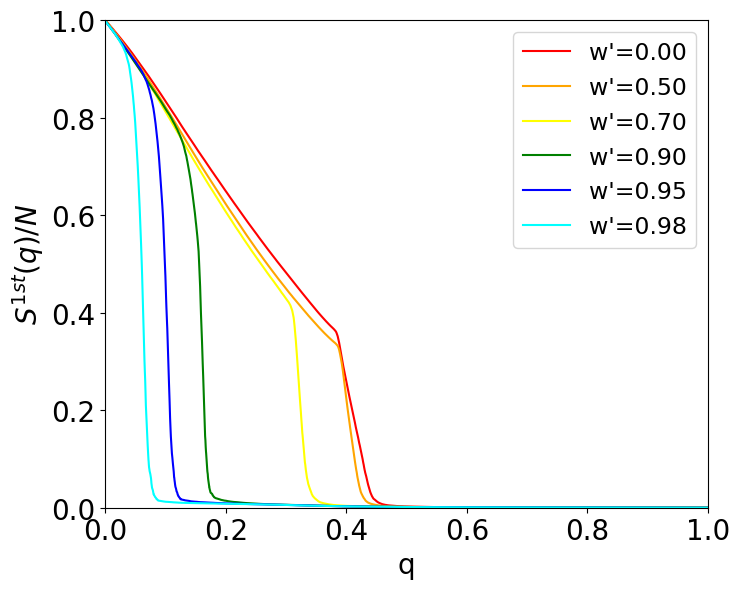

100%|██████████| 100/100 [04:20<00:00,  2.61s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


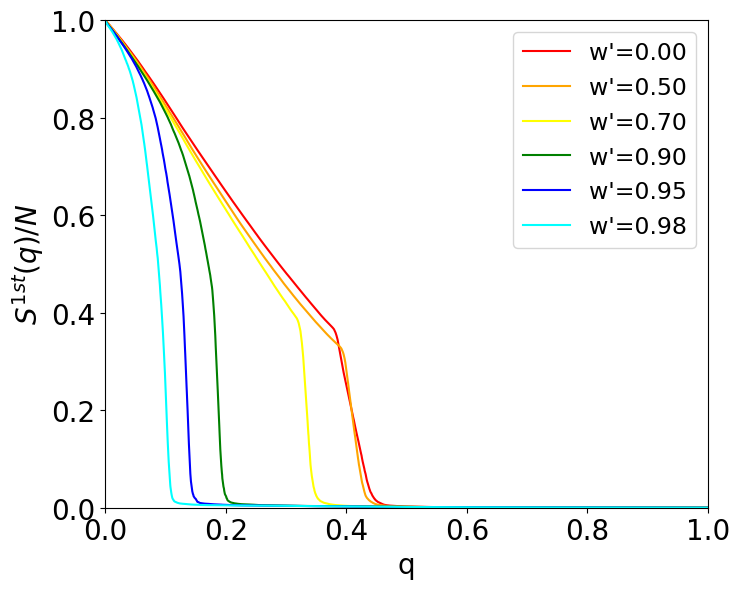

100%|██████████| 100/100 [03:19<00:00,  1.99s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


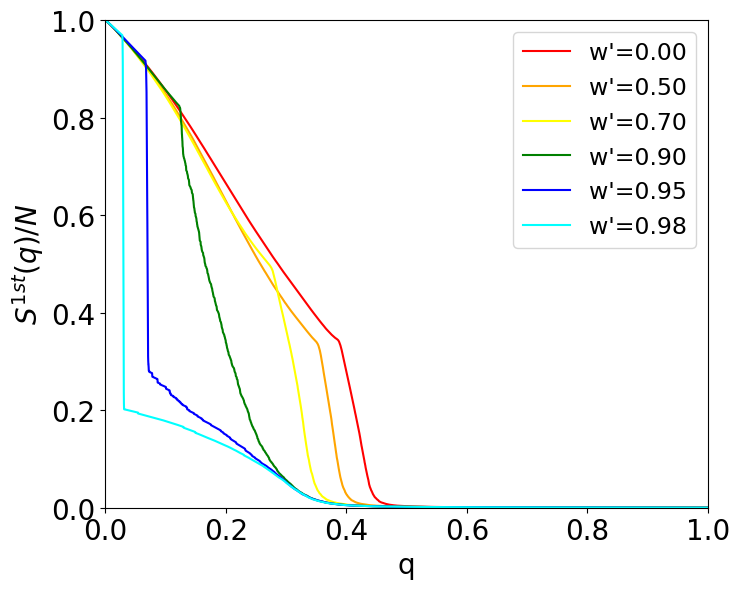

100%|██████████| 100/100 [03:21<00:00,  2.01s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


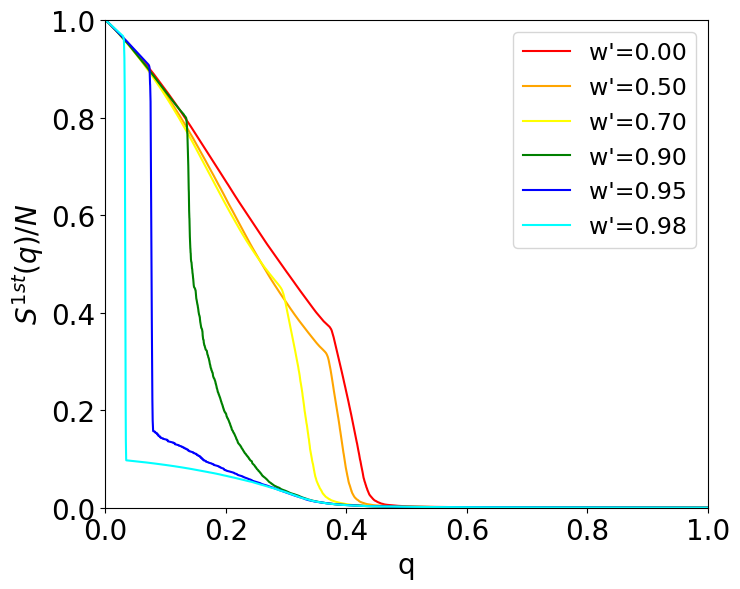

100%|██████████| 100/100 [03:18<00:00,  1.98s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


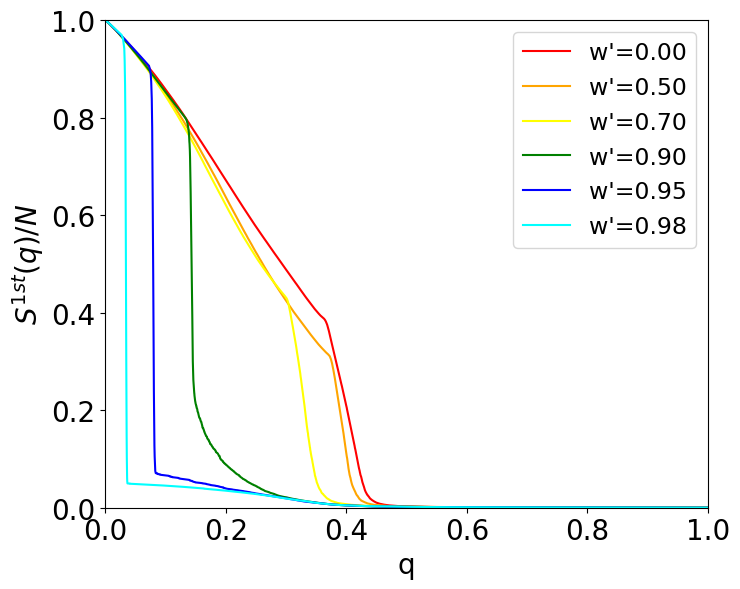

100%|██████████| 100/100 [03:17<00:00,  1.98s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


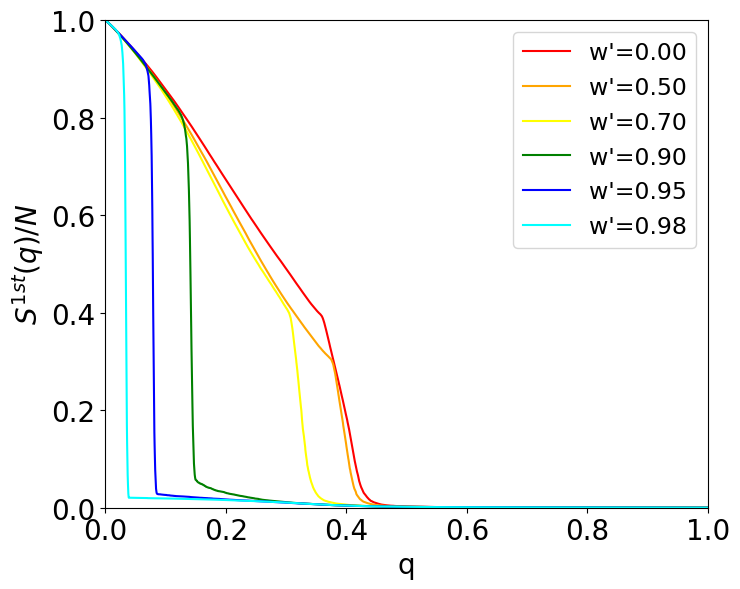

100%|██████████| 100/100 [03:15<00:00,  1.95s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


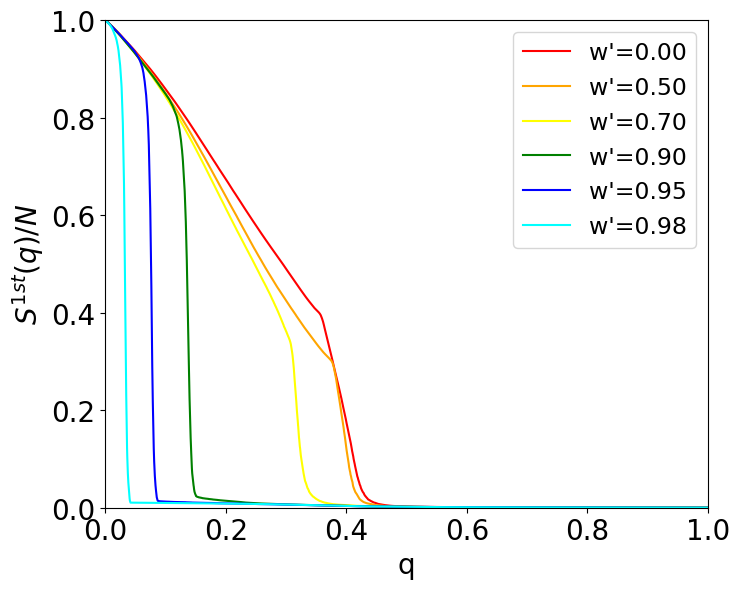

100%|██████████| 100/100 [03:12<00:00,  1.93s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


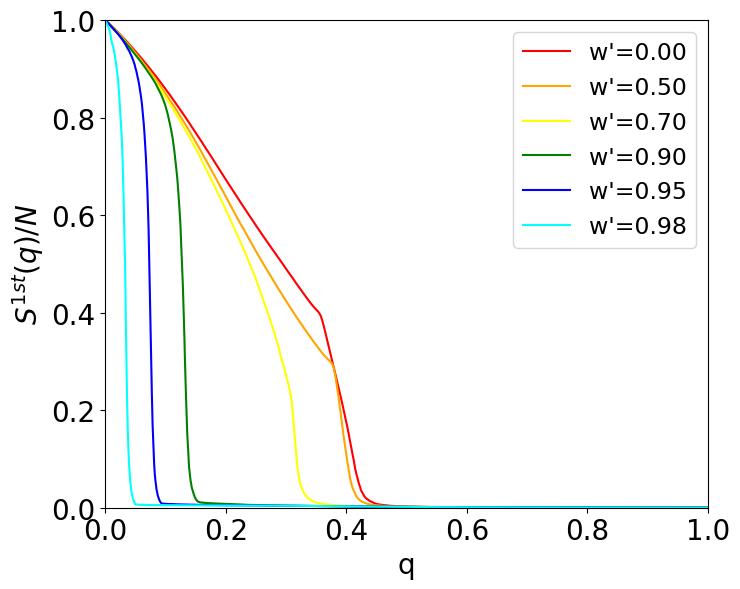

100%|██████████| 100/100 [03:25<00:00,  2.05s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


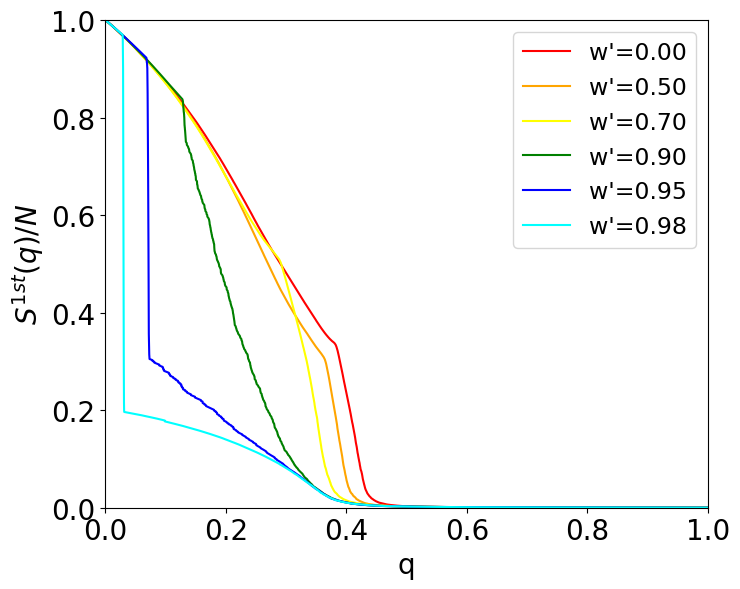

100%|██████████| 100/100 [03:28<00:00,  2.09s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


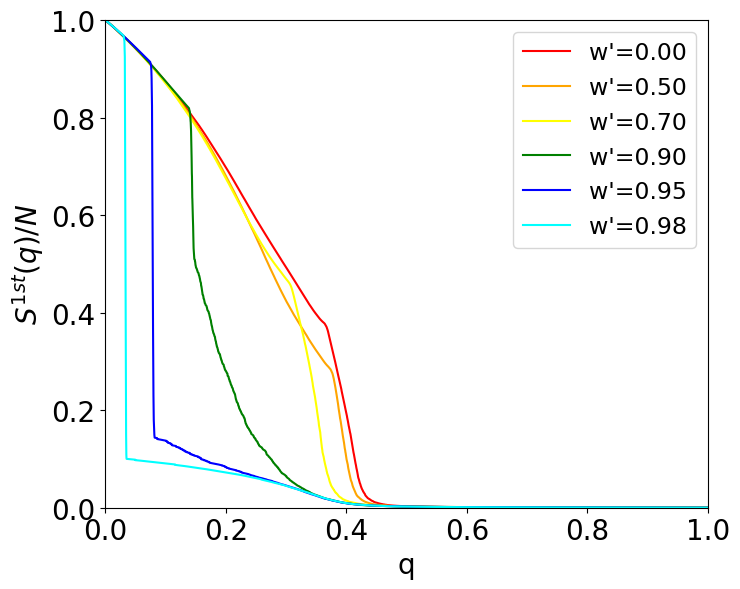

100%|██████████| 100/100 [03:25<00:00,  2.06s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


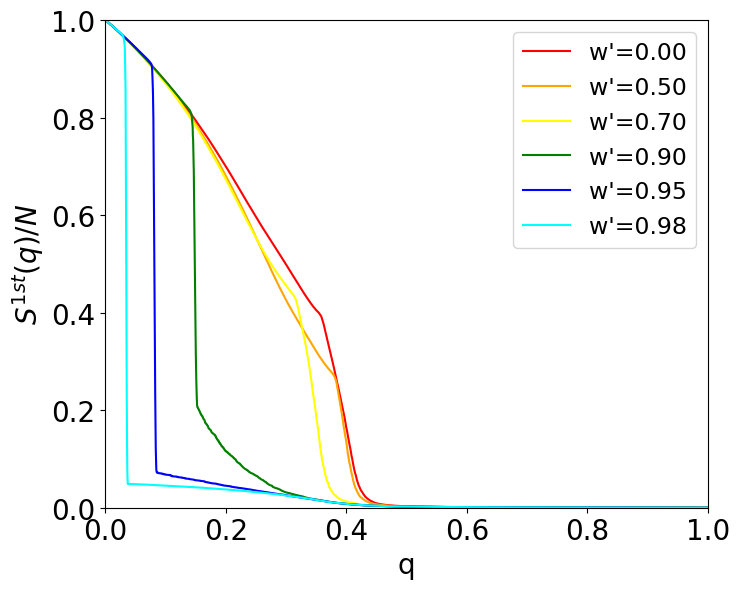

100%|██████████| 100/100 [03:23<00:00,  2.03s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


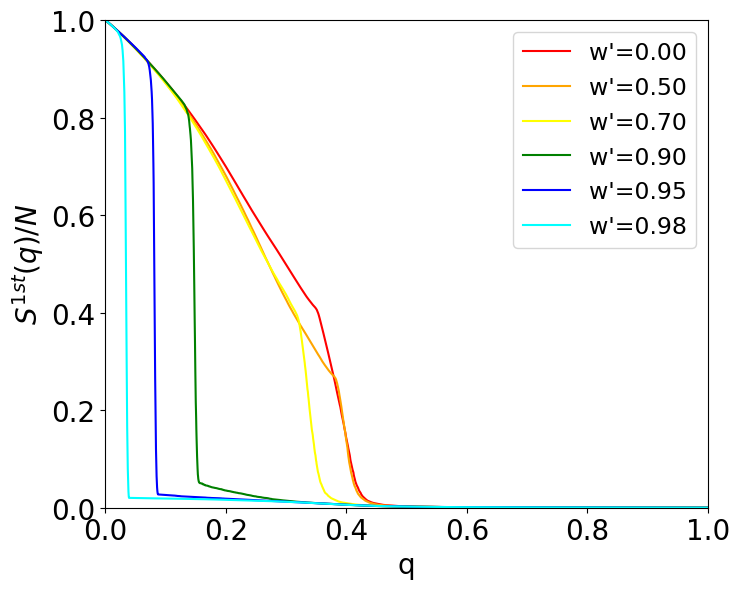

100%|██████████| 100/100 [03:21<00:00,  2.02s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


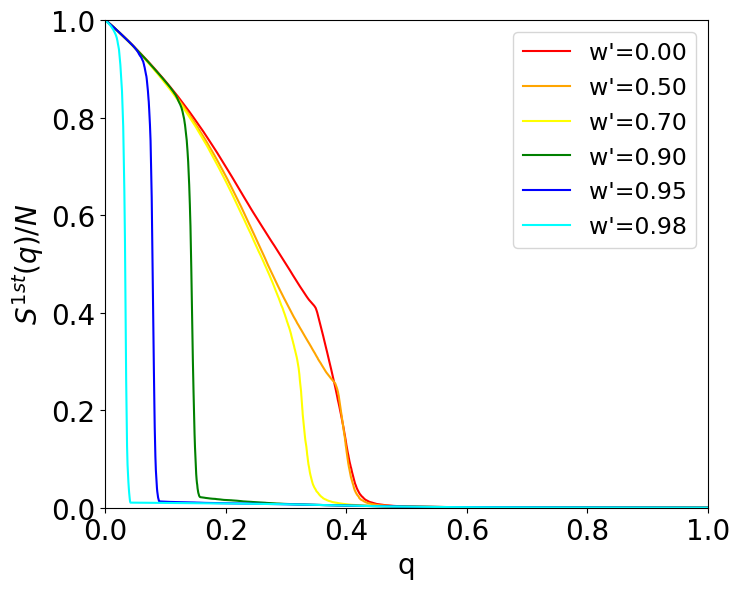

100%|██████████| 100/100 [03:16<00:00,  1.96s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


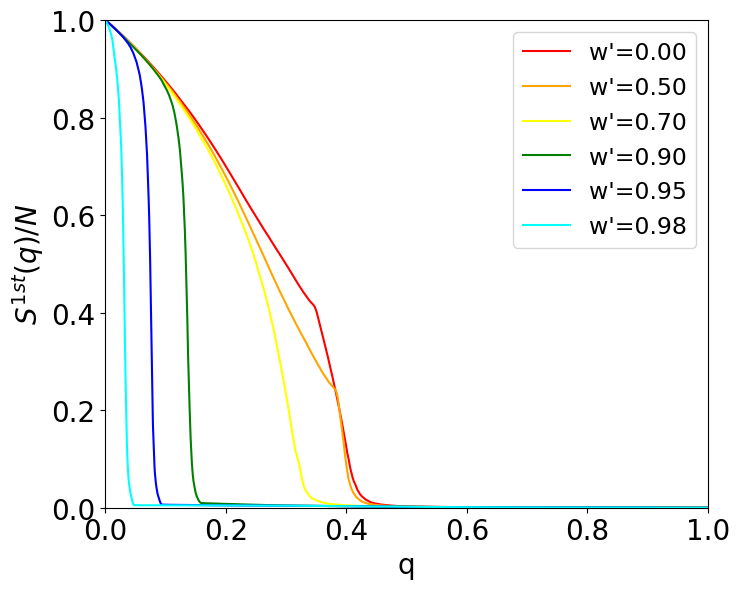

100%|██████████| 100/100 [03:32<00:00,  2.12s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


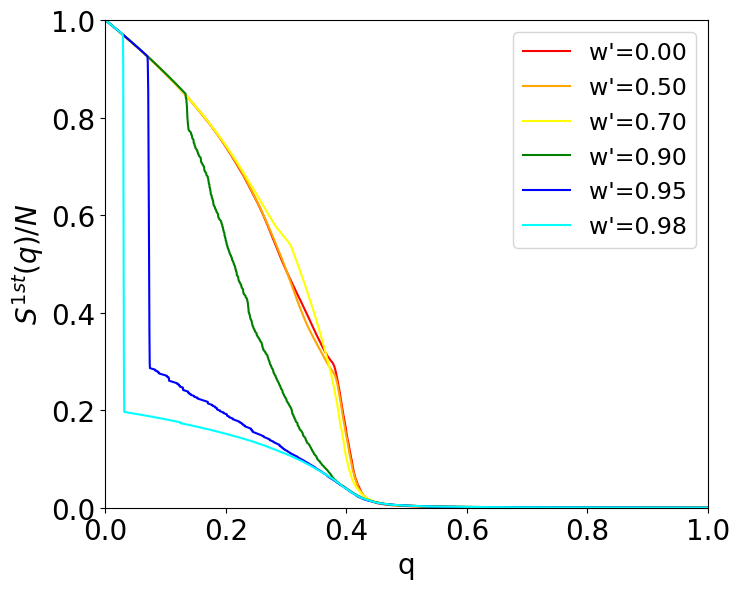

100%|██████████| 100/100 [03:30<00:00,  2.11s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


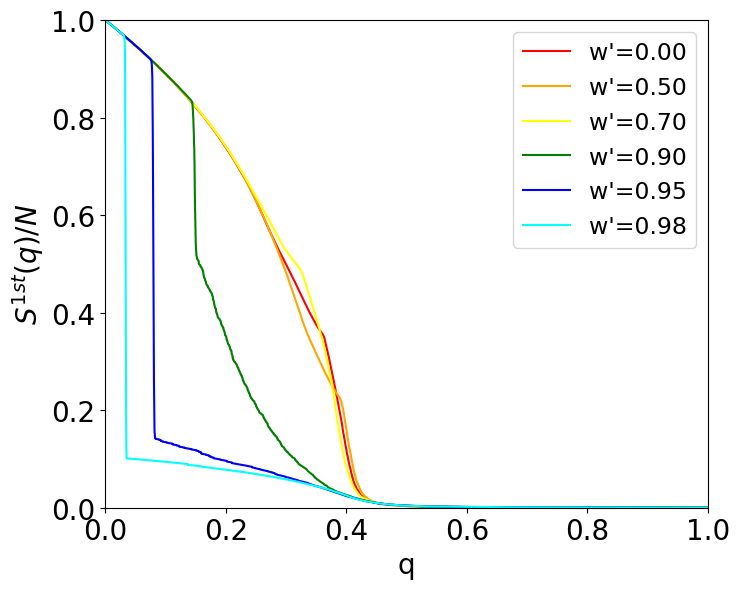

100%|██████████| 100/100 [03:32<00:00,  2.12s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


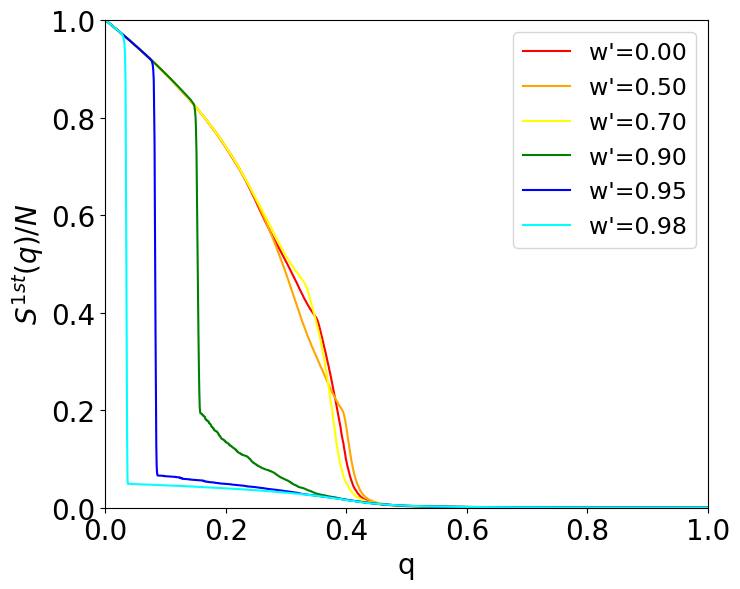

100%|██████████| 100/100 [03:29<00:00,  2.09s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


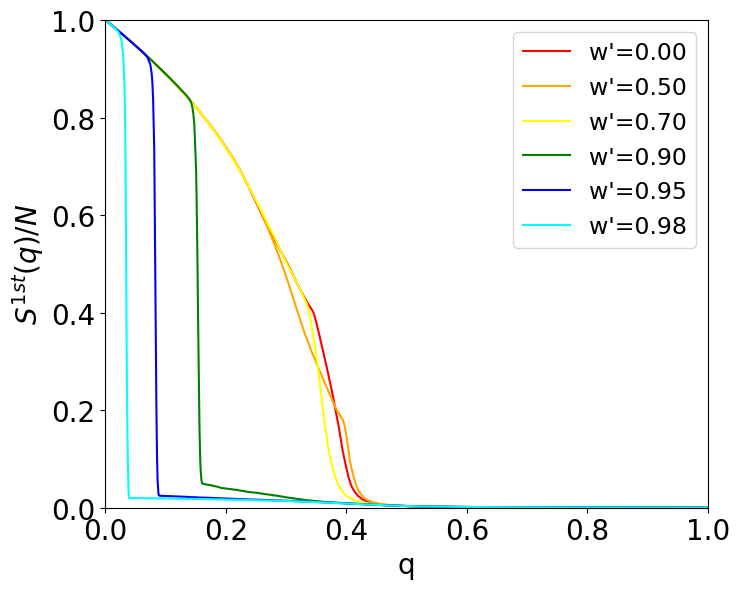

100%|██████████| 100/100 [03:29<00:00,  2.10s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


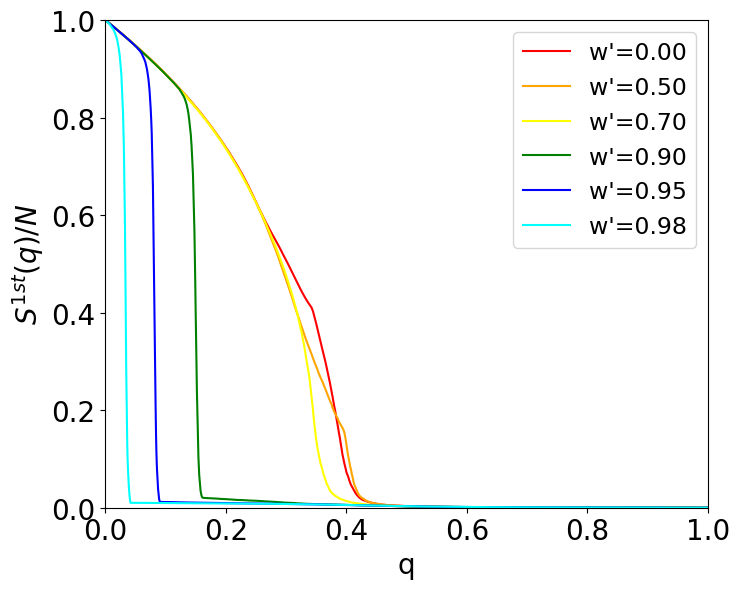

100%|██████████| 100/100 [03:22<00:00,  2.03s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


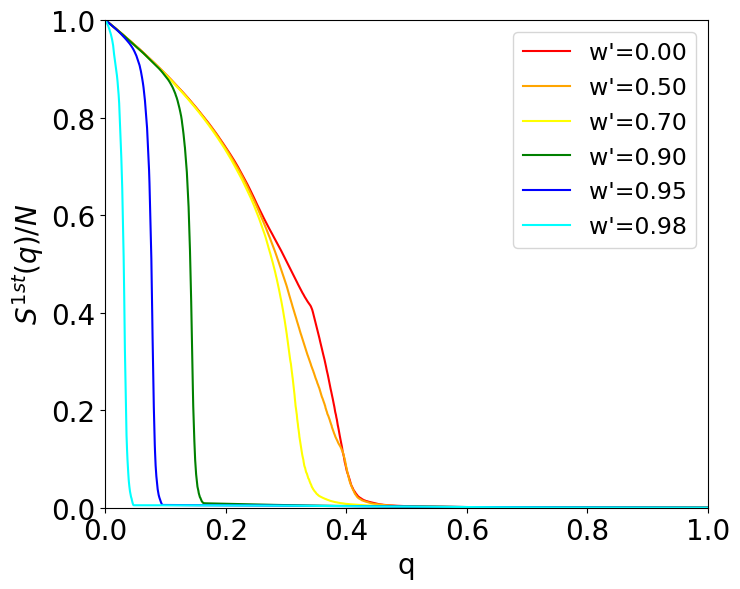

100%|██████████| 100/100 [03:33<00:00,  2.14s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


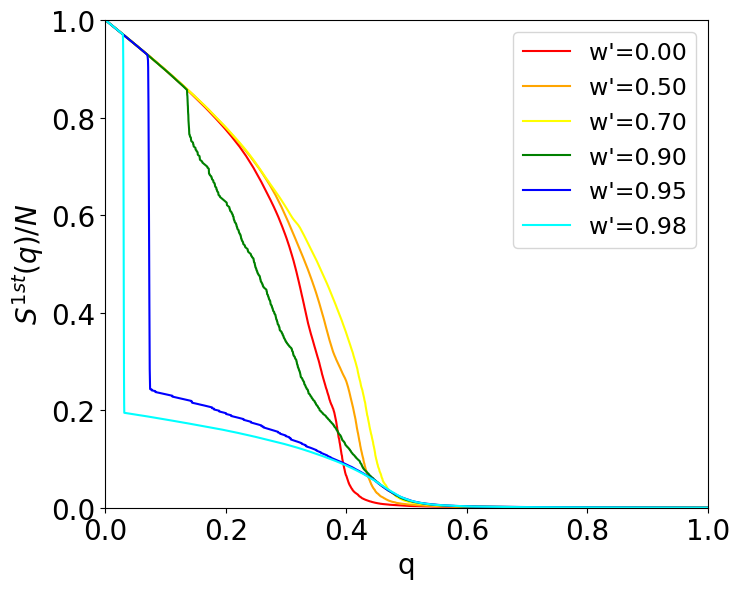

100%|██████████| 100/100 [03:37<00:00,  2.17s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


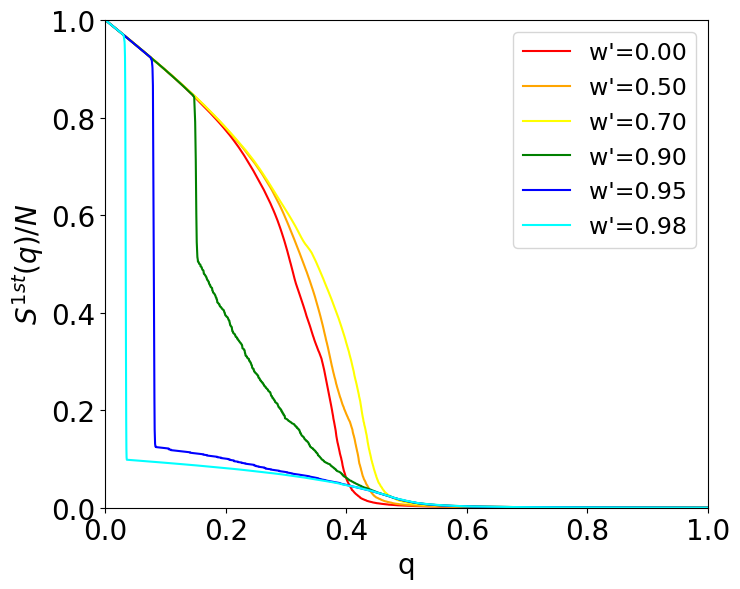

100%|██████████| 100/100 [03:33<00:00,  2.14s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


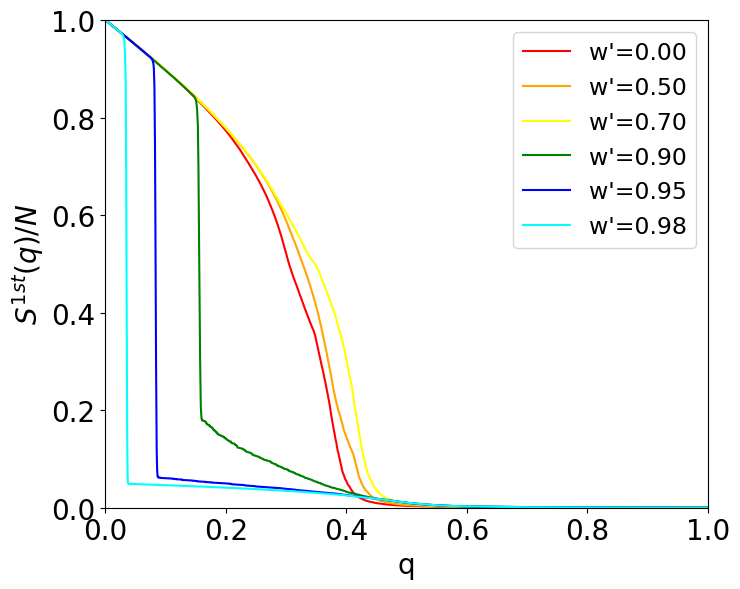

100%|██████████| 100/100 [03:34<00:00,  2.14s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


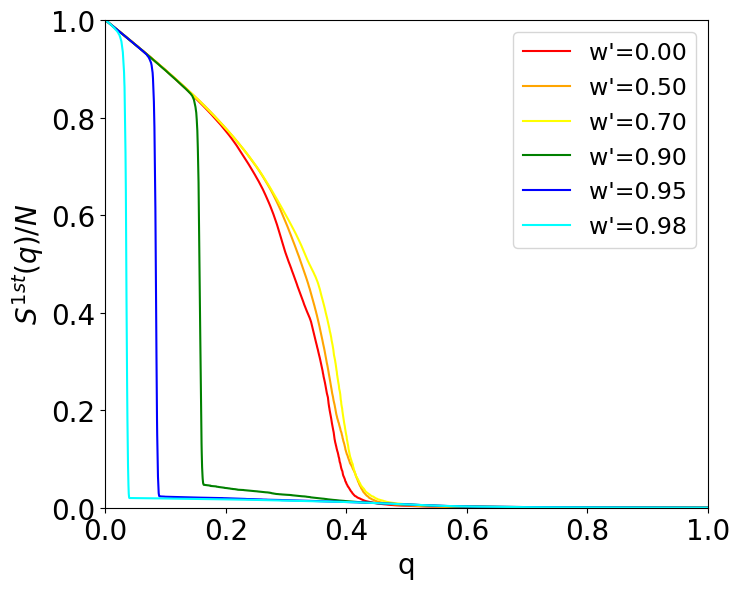

100%|██████████| 100/100 [03:34<00:00,  2.14s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


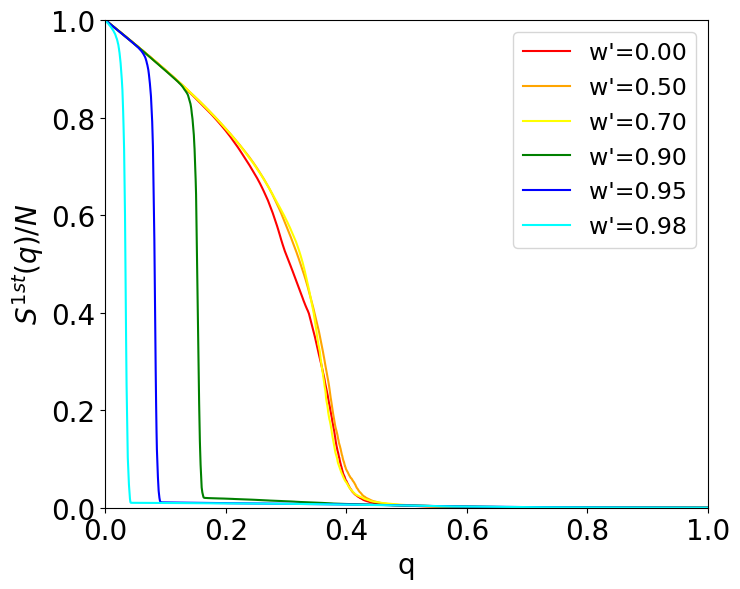

100%|██████████| 100/100 [03:29<00:00,  2.09s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


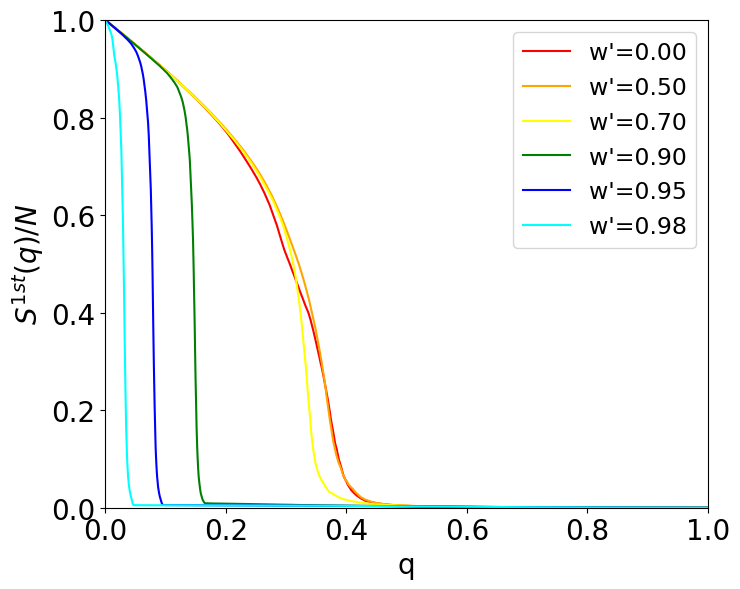

100%|██████████| 100/100 [03:34<00:00,  2.15s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


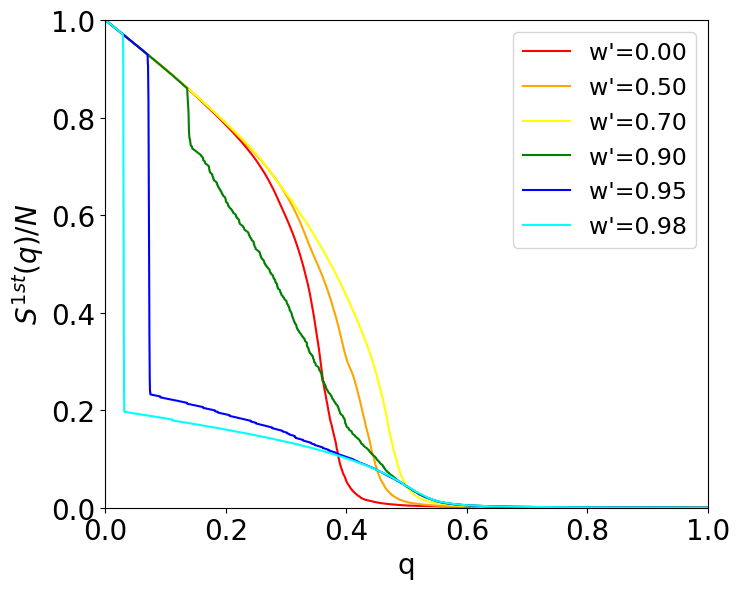

100%|██████████| 100/100 [03:37<00:00,  2.18s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


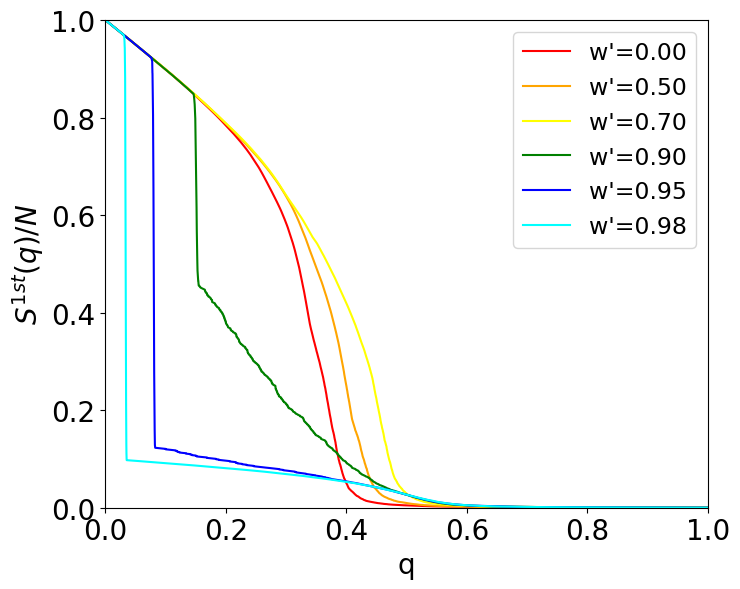

100%|██████████| 100/100 [03:35<00:00,  2.15s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


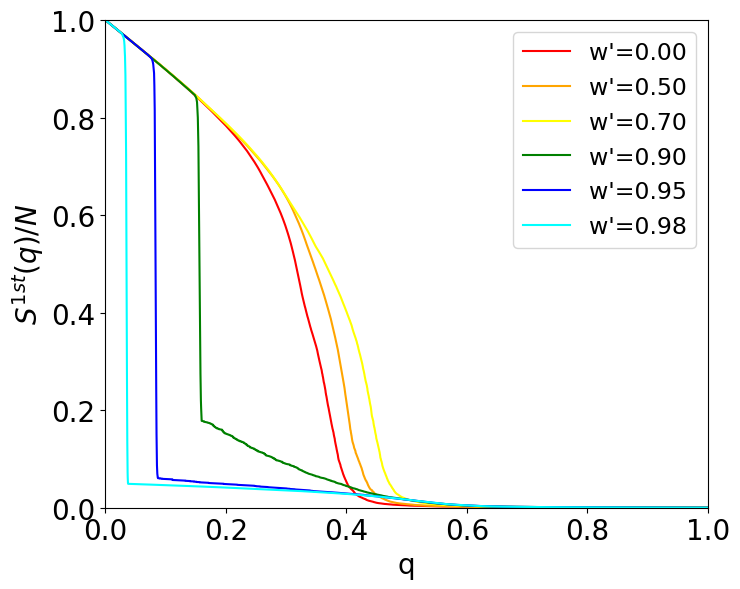

100%|██████████| 100/100 [03:33<00:00,  2.14s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


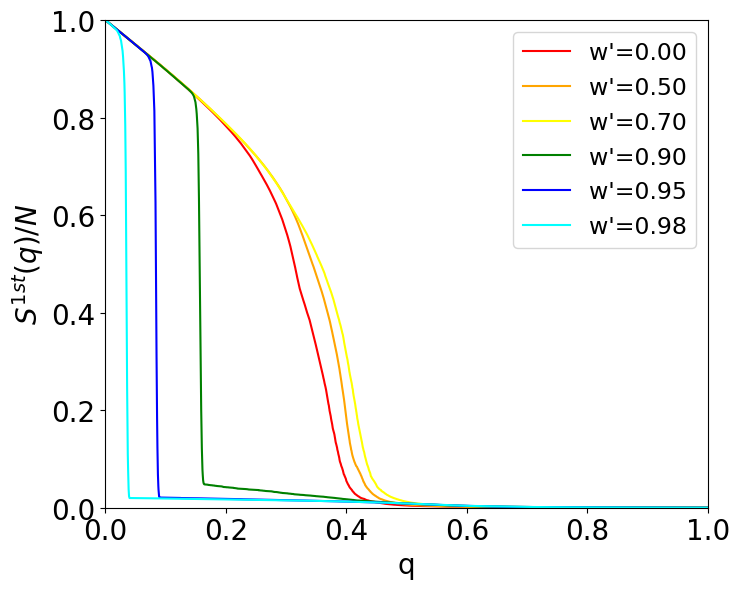

100%|██████████| 100/100 [03:31<00:00,  2.11s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


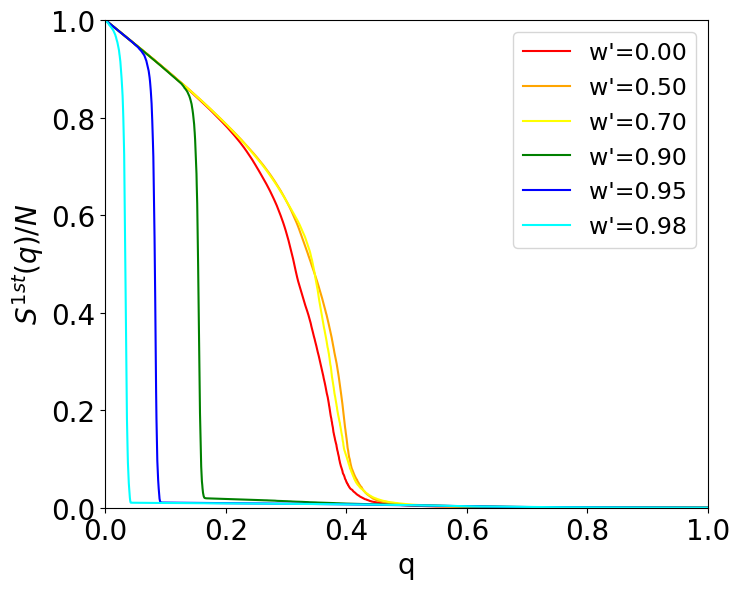

100%|██████████| 100/100 [03:29<00:00,  2.10s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


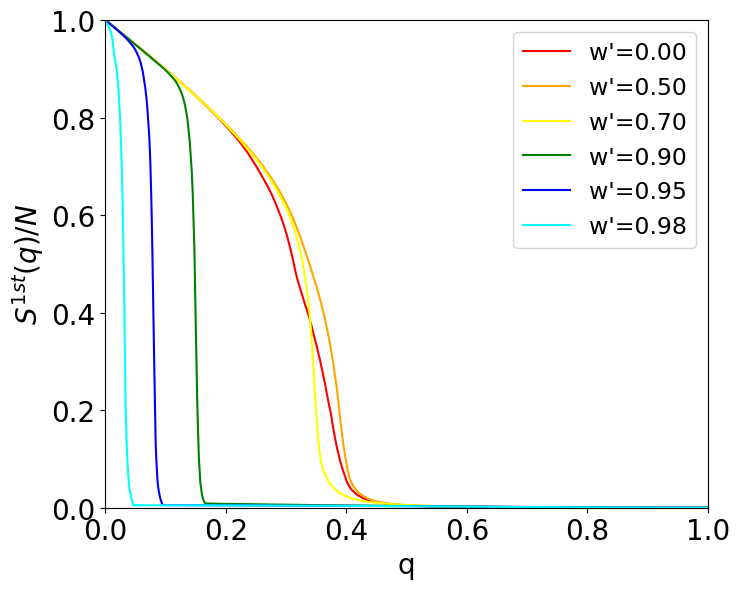

100%|██████████| 100/100 [03:11<00:00,  1.92s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


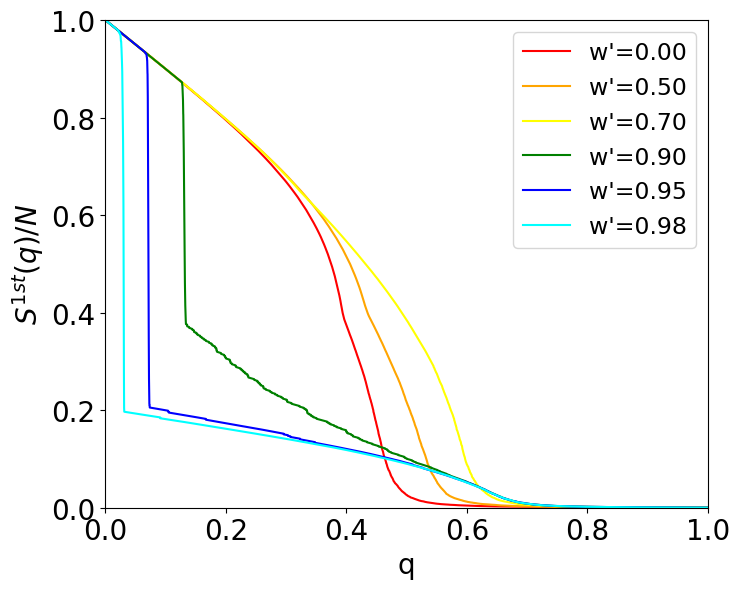

100%|██████████| 100/100 [03:15<00:00,  1.96s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


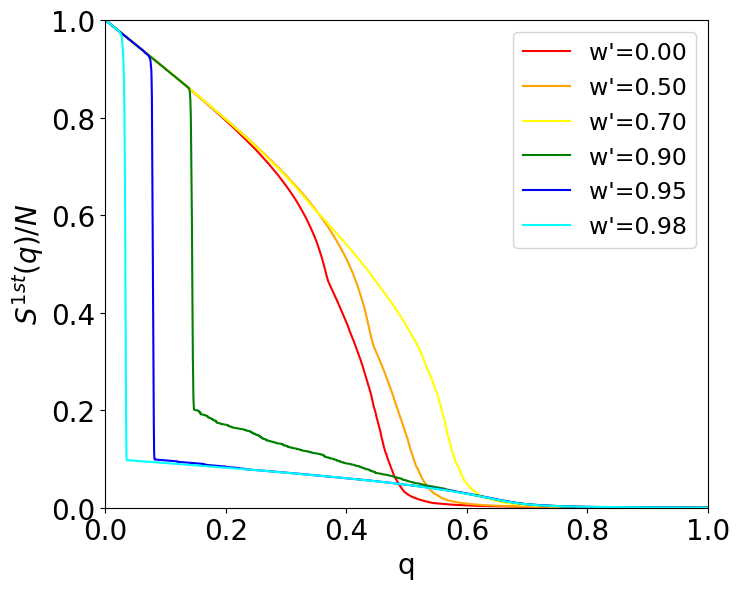

100%|██████████| 100/100 [03:16<00:00,  1.96s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


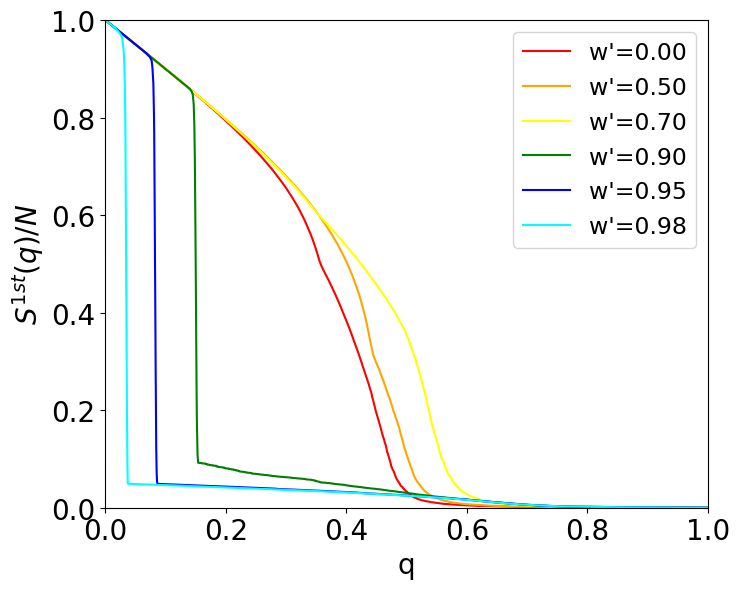

100%|██████████| 100/100 [03:15<00:00,  1.96s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


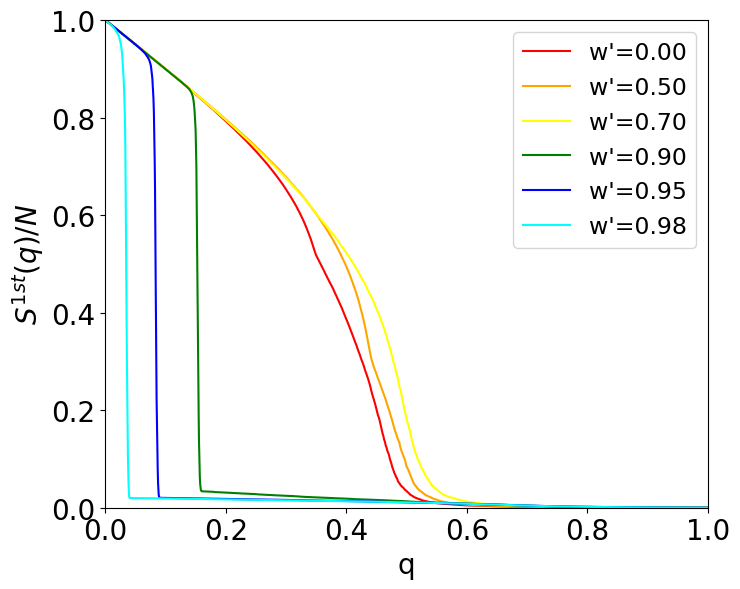

100%|██████████| 100/100 [03:16<00:00,  1.97s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


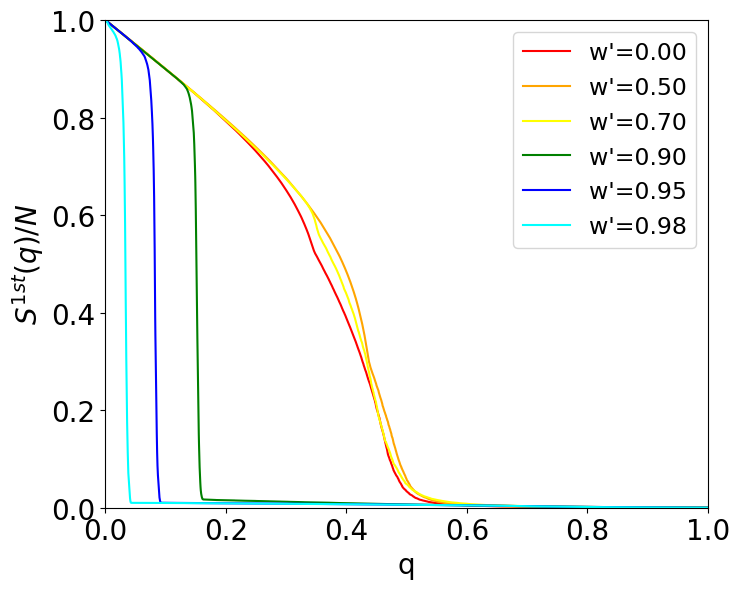

100%|██████████| 100/100 [03:16<00:00,  1.97s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


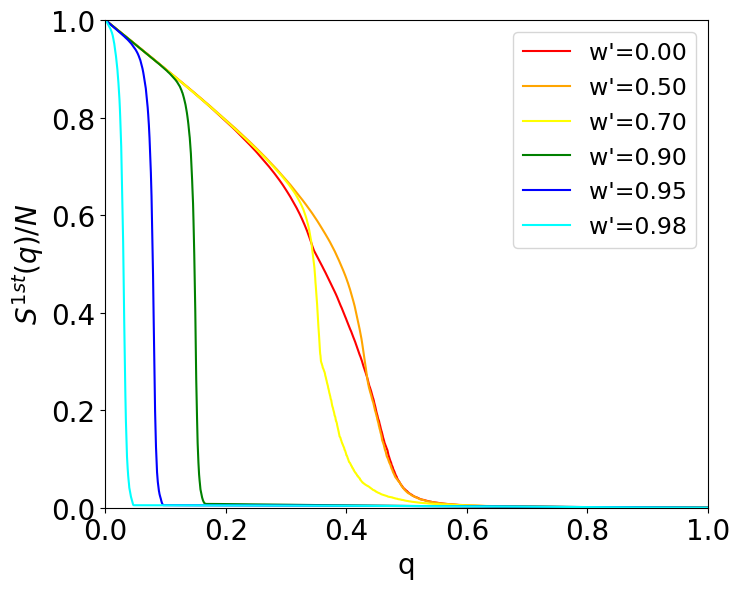

In [6]:
for net, beta in zip(net_list, beta_list):
    R_all_list = []
    Q_all_list = []
    for M in M_list:
        MB_avg_list =[]
        R_list = []
        Q_w_list = []
        for w in w_list: 
            MB = []
            Q_list = []
            for i in tqdm(range(times)):
                g = gt.load_graph(f"~/o_t_hayashilab/modular_net/{net}/w={w}/m0={M}/{i}.gt.gz")
                intra_link = inter_intra(g)
                module_base = module_based_attack(g, intra_link)
                sizes, comp = gt.vertex_percolation(g, module_base)
                module_attack = [frc for frc in sizes]
                perc = np.array(module_attack)
                perc = perc / n
                MB.append(perc)
                
                state = gt.BlockState(g, b=g.vp.module_number)
                Q = gt.modularity(g, state.get_blocks())
                Q_list.append(Q)
                
            MB_avg = np.mean(MB, axis=0)
            R = simpson(MB_avg, dx=1/n)
            MB_avg_list.append(MB_avg)
            R_list.append(R)
            
            Q_avg = np.mean(Q_list)
            Q_w_list.append(Q_avg)
            
        R_all_list.append(R_list)
        Q_all_list.append(Q_w_list)
        
        colors = ["red", "orange", "yellow", "green", "blue", "cyan", "purple", (0.03, 0.18, 0.42), (0.4, 0, 0.4)]
        rem_nd_frac = np.linspace(0, 1, num = n)
        plt.figure(figsize=(7.5, 6))
        for j in range(len(w_list)):
            data = MB_avg_list[j]
            label = f"w'={w_list[j]}"
            line = plt.plot(1 - rem_nd_frac, data, label=label, color=colors[j])
        
        plt.xlabel("q", fontsize=20)
        plt.ylabel(r"$S^{1st}(q)/N$", fontsize=20)
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.ylim(0, 1)
        plt.xlim(0, 1)
        plt.legend(loc="upper right", fontsize=17)
        plt.tight_layout()
        
        # 保存先のディレクトリを指定
        save_dir = os.path.expanduser('~/o_t_hayashilab/modular_net/MB_GC/')
        os.makedirs(save_dir, exist_ok=True)  # ディレクトリが存在しない場合は作成
        # EPS形式で図を保存（フルパスを指定）
        save_path = os.path.join(save_dir, f"GC_nu{beta}_mo{M}.eps")
        plt.savefig(save_path, format='eps', bbox_inches='tight')
        
        plt.show()

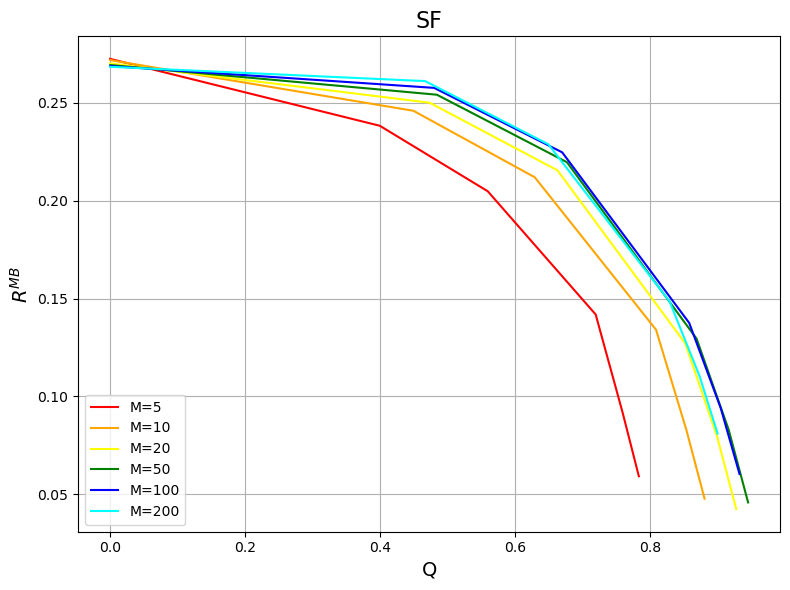

In [7]:
plt.figure(figsize=(8, 6))
for idx, M in enumerate(M_list):
    plt.plot(Q_all_list[idx], R_all_list[idx], label=f"M={M}", color = colors[idx])

plt.xlabel("Q", fontsize=14)
plt.ylabel(r"$R^{MB}$", fontsize=14)
plt.title(f"{net}", fontsize=16)
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()